# Un'analisi predittiva sulla serie tv più amata del mondo - I Simpson
## Esame di Programmazione di Applicazioni Data Intensive
#### Laurea in Ingegneria e Scienze Informatiche - A.A. 2019/2020
#### Matteo Castellucci - matteo.castellucci3@studio.unibo.it

### Descrizione del problema e della variabile da predire

Si vogliono analizzare le caratteristiche degli episodi della serie tv "I Simpson" (in originale "The Simpsons") con il fine di predire quanto più accuratamente possibile il [*rating* su IMDB](https://www.imdb.com/title/tt0096697/) di ciascun episodio. Immaginiamo perciò che tutti gli episodi non siano ancora andati in onda, in modo tale che gli spettatori non abbiano ancora potuto farsene un'opinione, ma che siano già stati prodotti e ne sia stata programmata la trasmissione, in modo tale da sapere in anticipo il contenuto di ciascuno di essi e la data in cui saranno trasmessi.

Poichè il valore assoluto del *rating* di per sè è per noi poco significativo, essendo legato alle esperienze personali degli spettatori, cercheremo di predire una variabile categorica ottenuta da esso che ci dica se l'episodio complessivamente è ritenuto "bello" oppure "brutto" dal pubblico.
Scegliamo le classi secondo la seguente logica:
- **Bello**: rating superiore a 7,5 incluso
- **Brutto**: rating inferiore a 7,5 escluso  

Dovremo perciò affrontare un problema di classificazione binaria.

### Importazione delle librerie e impostazione delle opzioni

Per prima cosa ci preoccupiamo di importare tutte le librerie, le funzioni e gli oggetti che utilizzeremo. Inoltre, scarichiamo tutti i componenti della libreria "NLTK" che ci serviranno e impostiamo tutte le proprietà delle librerie a noi utili, in modo da non doverlo fare più avanti. Sopprimiamo inoltre i *warning* inutili.

In [1]:
%matplotlib inline
import os.path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from scipy.stats import norm
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBClassifier
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv1D, Flatten, Dropout, Reshape
from keras.regularizers import l2
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.display.max_colwidth = 100
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /home/matteo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/matteo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/matteo/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Importazione del dataset

Verranno utilizzati i *dataset* contenuti nel post "The Simpsons by the data" originariamente pubblicati da William Kukierski e, data la loro cancellazione dal sito "Kaggle", aggiunti nuovamente da Prashant Banerjee. Mi sono riservato di applicare alcune modifiche al dataset originale per renderlo importabile tramite la libreria "Pandas", visto che presentava alcuni errori di formattazione. Detto questo, lo scarichiamo e lo importiamo.

In [2]:
zip_filename = "the_simpsons.zip"
if not os.path.exists("the_simpsons.zip"):
    from urllib.request import urlretrieve
    urlretrieve("https://drive.google.com/uc?export=download&id=1M4xsnaYl5KfsQ9Wx7wQ9Jc5oBdeCPcTx", zip_filename)
    from zipfile import ZipFile
    with ZipFile(zip_filename) as file:
        file.extractall()

### Comprensione dei dati

Osserviamo per prima cosa i personaggi. Notiamo che ogni riga ha già un suo identificatore dato dalla colonna ``id`` e che, oltre a questa colonna, nel file sono presenti altre tre *feature*:

- ``name``: il nome del personaggio
- ``normalized_name``: il nome del personaggio costituito da soli caratteri alfabetici minuscoli
- ``gender``: il genere sessuale del personaggio

In [3]:
simpsons_characters = pd.read_csv("simpsons_characters.csv", index_col="id").sort_values("id")
simpsons_characters.iloc[5:15]

,name,normalized_name,gender
id,,,
6,Dewey Largo,dewey largo,m
7,Children,children,NaN
8,Bart Simpson,bart simpson,m
9,Lisa Simpson,lisa simpson,f
10,Patty Bouvier,patty bouvier,f
11,Ned Flanders,ned flanders,m
12,Mechanical Santa,mechanical santa,NaN
13,Tattoo Man,tattoo man,NaN
14,Waylon Smithers,waylon smithers,m


Come si può notare, la stragrande maggioranza dei personaggi non ha genere - perchè è sconosciuto o perché il personaggio è un insieme di persone - e perciò non è per noi un elemento particolarmente significativo. Questo DataFrame verrà perciò utilizzato solo per identificare il nome dei personaggi, in quanto non riporta altro che tutti i possibili nomi di personaggi contenuti nei copioni dei vari episodi, essendo presenti solo nomi unici.

In [4]:
simpsons_characters.describe().loc[["count", "unique"]]

,name,normalized_name,gender
count,6722,6722,323
unique,6722,6722,2


Possiamo perciò già provvedere alla rimozione delle colonne non necessarie.

In [5]:
simpsons_characters.drop(columns=["normalized_name", "gender"], inplace=True)
simpsons_characters.head()

,name
id,
1,Marge Simpson
2,Homer Simpson
3,Seymour Skinner
4,JANEY
5,Todd Flanders


Questo, come vedremo anche per gli altri, è un *dataset* molto pesante in memoria perchè contiene un numero molto alto di istanze (6722 per la precisione). Per questo, modifichiamo il tipo delle sue colonne in modo da ottimizzare al massimo l'uso della memoria sfruttando i tipi di Pandas. In questo modo, riusciamo a ridurre lo spazio occupato di quasi 5 volte.

In [6]:
simpsons_characters.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6722 entries, 1 to 6749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    6722 non-null   object
dtypes: object(1)
memory usage: 506.4 KB


In [7]:
simpsons_characters = simpsons_characters.astype({
    "name": "string",
})
simpsons_characters.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6722 entries, 1 to 6749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    6722 non-null   string
dtypes: string(1)
memory usage: 105.0 KB


Osservando le location notiamo un pattern simile a quello già visto per i personaggi: abbiamo una colonna ``id`` che rappresenta l'identificatore della *location*, mentre le *feature* vere e proprie sono:

- ``name``: il nome della *location*
- ``normalized_name``: il nome della *location* fatto di soli caratteri alfabetici in minuscolo

In [8]:
simpsons_locations = pd.read_csv("simpsons_locations.csv", index_col="id").sort_values("id")
simpsons_locations.head()

,name,normalized_name
id,,
1,Street,street
2,Car,car
3,Springfield Elementary School,springfield elementary school
4,Auditorium,auditorium
5,Simpson Home,simpson home


Anche in questo caso, il "DataFrame" è solamente utile per identificare il nome dei vari luoghi in cui gli episodi si svolgono, contenendo i luoghi che compaiono nei copioni dei vari episodi un'unica volta.

In [9]:
simpsons_locations.describe().loc[["count", "unique"]]

,name,normalized_name
count,4459,4459
unique,4459,4459


Possiamo perciò rimuovere ``normalized_name``, non essendoci di alcuna utilità.

In [10]:
simpsons_locations.drop(columns="normalized_name", inplace=True)
simpsons_locations.head()

,name
id,
1,Street
2,Car
3,Springfield Elementary School
4,Auditorium
5,Simpson Home


In questo caso l'uso di memoria incide di meno rispetto al dataset precedente. Decidiamo però lo stesso di scegliere i tipi adeguati per le colonne del DataFrame, anche solo per coerenza con il caso precedente, e otteniamo anche in questo caso una diminuzione nell'uso di memoria di un fattore 5.

In [11]:
simpsons_locations.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 1 to 4459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4459 non-null   object
dtypes: object(1)
memory usage: 356.8 KB


In [12]:
simpsons_locations = simpsons_locations.astype({
    "name": "string",
})
simpsons_locations.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 1 to 4459
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4459 non-null   string
dtypes: string(1)
memory usage: 69.7 KB


Il terzo dataset invece è quello che contiene i dati relativi ai singoli episodi. In esso troviamo un identificatore per ciascun episodio contraddistinto dal nome ``id``, come nei precedenti dataset, mentre le altre sue feature sono:

- ``image_url``: l'URL del *frame* che rappresenta l'episodio
- ``imdb_rating``: il *rating* che l'episodio ha su IMDB
- ``imdb_votes``: il numero di voti che hanno contribuito al *rating* su IMDB
- ``number_in_season``: il numero dell'episodio all'interno della stagione
- ``number_in_series``: il numero dell'episodio all'interno dell'intera serie
- ``original_air_date``: la data della prima trasmissione dell'episodio
- ``original_air_year``: l'anno della prima trasmissione dell'episodio
- ``production_code``: il codice di produzione dell'episodio
- ``season``: il numero della stagione dell'episodio
- ``title``: il titolo dell'episodio
- ``us_viewers_in_millions``: il numero di spettatori negli Stati Uniti per quell'episodio in milioni
- ``video_url``: l'URL per vedere l'episodio sul sito del canale televisivo "Fox"
- ``views``: il numero di visualizzazioni dell'episodio sul sito del canale televisivo "Fox"

In [13]:
simpsons_episodes = pd.read_csv("simpsons_episodes.csv", index_col="id").sort_values("id")
simpsons_episodes.head()

,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
id,,,,,,,,,,,,,
1,http://static-media.fxx.com/img/FX_Networks_-_FXX/617/479/Simpsons_01_08.jpg,8.2,3734.0,1,1,1989-12-17,1989,7G08,1,Simpsons Roasting on an Open Fire,26.7,http://www.simpsonsworld.com/video/273376835817,171408.0
2,http://static-media.fxx.com/img/FX_Networks_-_FXX/265/167/Simpsons_01_02.jpg,7.8,1973.0,2,2,1990-01-14,1990,7G02,1,Bart the Genius,24.5,http://www.simpsonsworld.com/video/283744835990,91423.0
3,http://static-media.fxx.com/img/FX_Networks_-_FXX/621/883/Simpsons_01_03.jpg,7.5,1709.0,3,3,1990-01-21,1990,7G03,1,Homer's Odyssey,27.5,http://www.simpsonsworld.com/video/273381443699,78072.0
4,http://static-media.fxx.com/img/FX_Networks_-_FXX/632/119/Simpsons_01_04__343617.jpg,7.8,1701.0,4,4,1990-01-28,1990,7G04,1,There's No Disgrace Like Home,20.2,http://www.simpsonsworld.com/video/273392195780,67378.0
5,http://static-media.fxx.com/img/FX_Networks_-_FXX/274/735/Simpsons_01_05.jpg,8.1,1732.0,5,5,1990-02-04,1990,7G05,1,Bart the General,27.1,http://www.simpsonsworld.com/video/300934723994,63129.0


Colonne come ``image_url`` e ``video_url`` non sono di alcuna utilità, così come gli identificatori alternativi per l'episodio - ovvero ``number_in_season``, ``number_in_series``, ``production_code`` - essendoci già un identificatore. Le feature ``imdb_votes``, ``us_viewers_in_millions`` e ``views`` non sono note in anticipo per come abbiamo descritto il problema e ``original_air_year`` è una feature duplicata. Per tutte queste ragioni, le colonne descritte verranno eliminate dal DataFrame.

In [14]:
simpsons_episodes.drop(columns=simpsons_episodes.columns.difference(["imdb_rating", "original_air_date", "season", "title"]), inplace=True)
simpsons_episodes.head()

,imdb_rating,original_air_date,season,title
id,,,,
1,8.2,1989-12-17,1,Simpsons Roasting on an Open Fire
2,7.8,1990-01-14,1,Bart the Genius
3,7.5,1990-01-21,1,Homer's Odyssey
4,7.8,1990-01-28,1,There's No Disgrace Like Home
5,8.1,1990-02-04,1,Bart the General


In questo caso l'uso di memoria è insignificante, ma per poter essere compatibile con i precedenti dataset dobbiamo trasformarlo utilizzando i tipi di dato adeguati, che inevitabilmente ci fa risparmiare non poca memoria, ben più dei tre quarti dell'originale.

In [15]:
simpsons_episodes.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_rating        597 non-null    float64
 1   original_air_date  600 non-null    object 
 2   season             600 non-null    int64  
 3   title              600 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 99.0 KB


In [16]:
simpsons_episodes = simpsons_episodes.astype({
    "title": "string"
})
simpsons_episodes["original_air_date"] = pd.to_datetime(simpsons_episodes["original_air_date"])
simpsons_episodes.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_rating        597 non-null    float64       
 1   original_air_date  600 non-null    datetime64[ns]
 2   season             600 non-null    int64         
 3   title              600 non-null    string        
dtypes: datetime64[ns](1), float64(1), int64(1), string(1)
memory usage: 23.4 KB


Nell'ultimo dataset sono invece contenute tutte le battute dei copioni dei vari episodi. Oltre alla colonna ``id`` che fa da identificatore, già vista nei precedenti DataFrame, troviamo:
- ``episode_id``: l'identificatore dell'episodio, utile per effettuare join con il DataFrame che contiene gli episodi
- ``number``: il numero della battuta all'interno del copione dell'episodio
- ``raw_text``: il testo della battuta così com'è stato trovato nel copione
- ``timestamp_in_ms``: il *timestamp* dell'istante in cui la battuta viene pronunciata all'interno dell'episodio
- ``speaking_line``: se la battuta viene pronunciata da qualcuno o semplicemente sono appunti di sceneggiatura
- ``character_id``: l'identificatore del personaggio che pronuncia la battuta
- ``location_id``: l'identificatore della location in cui viene pronunciata la battuta
- ``raw_character_text``: il nome del personaggio che pronuncia la battuta
- ``raw_location_text``: il nome della location in cui la battuta viene pronunciata
- ``spoken_words``: il testo della battuta con rimossi i suggerimenti di interpretazione e il nome di chi la pronuncia
- ``normalized_text``: come ``spoken_words`` ma sono stati rimossi tutti i caratteri non alfabetici e quelli rimasti sono stati convertiti in minuscolo
- ``word_count``: il conteggio delle parole pronunciate nella battuta

In [17]:
simpsons_script_lines = pd.read_csv("simpsons_script_lines.csv", index_col="id").sort_values("id")
simpsons_script_lines.iloc[5:10]

,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
id,,,,,,,,,,,,
6,1,5,(Springfield Elementary School: Ext. springfield elementary school - establishing - night),24000.0,False,NaN,3.0,NaN,Springfield Elementary School,NaN,NaN,NaN
7,1,6,(Auditorium: int. auditorium - night),24000.0,False,NaN,4.0,NaN,Auditorium,NaN,NaN,NaN
8,1,7,"Marge Simpson: (HUSHED VOICE) Sorry, Excuse us. Pardon me...",24000.0,True,1.0,4.0,Marge Simpson,Auditorium,"Sorry, Excuse us. Pardon me...",sorry excuse us pardon me,5.0
9,1,8,"Homer Simpson: (SIMULTANEOUSLY) Hey, Norman. How's it going? So you got dragged down here, too.....",26000.0,True,2.0,4.0,Homer Simpson,Auditorium,"Hey, Norman. How's it going? So you got dragged down here, too... heh, heh. How ya doing, Fred? ...",hey norman hows it going so you got dragged down here too heh heh how ya doing fred excuse me fred,21.0
10,1,9,Homer Simpson: Pardon my galoshes. (CHUCKLES),34000.0,True,2.0,4.0,Homer Simpson,Auditorium,Pardon my galoshes.,pardon my galoshes,3.0


La colonna ``raw_text``, benchè possa sembrare utile, in realtà può essere eliminata, perchè sono le colonne successive a mantenere i suoi dati utili in una forma più leggibile. L'unico caso in cui sembrerebbero perdersi delle informazioni si ha quando la battuta non è pronunciata ed indica un cambio di location o lo specifico momento del giorno in cui si svolge la scena. Il luogo che può contenere però è presente nelle feature ``location_id`` e ``raw_location_text`` delle battute seguenti, mentre il momento del giorno non è un'informazione particolarmente significativa e possiamo anche rinunciarvi. Inoltre, ``spoken_words`` è migliore di ``raw_text`` anche perchè non presenta i suggerimenti di interpretazione, che non servono per far capire che cosa sta succedendo durante quella battuta, e perchè chi pronuncia la battuta è già indicato dalle colonne ``character_id`` e ``raw_character_text``. Tratterremo ``raw_text`` solo per il momento perchè ci servirà per l'elaborazione dei dati succssiva, ma poi ce ne sbarazzeremo. La feature ``speaking_line`` non è necessaria da trattenere poichè tutte le righe che hanno la colonna ``spoken_words`` diversa da NA hanno anche ``speaking_line`` posto a True, rendendolo un attributo derivato al pari di ``normalized_text``, ``word_count``, ``raw_character_text`` e ``raw_location_text``. Possiamo perciò eliminare tutte queste colonne tranquillamente. La feature ``timestamp_in_ms`` non ci dà alcuna informazione utile e perciò rimuoviamo anche questa.

In [18]:
simpsons_script_lines[(simpsons_script_lines["speaking_line"] == True) & (simpsons_script_lines["spoken_words"].isna())].size

0

In [19]:
simpsons_script_lines.drop(columns=simpsons_script_lines.columns.difference(["episode_id", "number", "raw_text", "character_id", "location_id", "spoken_words"]), inplace=True)
simpsons_script_lines.head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
1,1,0,(Street: ext. street - establishing - night),NaN,1.0,NaN
2,1,1,(Car: int. car - night),NaN,2.0,NaN
3,1,2,"Marge Simpson: Ooo, careful, Homer.",1.0,2.0,"Ooo, careful, Homer."
4,1,3,Homer Simpson: There's no time to be careful.,2.0,2.0,There's no time to be careful.
5,1,4,Homer Simpson: We're late.,2.0,2.0,We're late.


Per quest'ultimo DataFrame l'uso della memoria è importantissimo, dato che occupa circa 40 MiB. Anche in questo caso ci affidiamo all'uso dei tipi di dato di Pandas per migliorare l'uso della memoria, che però viene ridotto solo di 13 MiB.

In [20]:
simpsons_script_lines.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158301 entries, 1 to 158315
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   episode_id    158301 non-null  int64  
 1   number        158301 non-null  int64  
 2   raw_text      158301 non-null  object 
 3   character_id  140760 non-null  float64
 4   location_id   157878 non-null  float64
 5   spoken_words  132139 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 39.7 MB


In [21]:
simpsons_script_lines = simpsons_script_lines.astype({
    "character_id": pd.Int64Dtype(),
    "location_id": pd.Int64Dtype(),
    "spoken_words": "string"
})
simpsons_script_lines.head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
1,1,0,(Street: ext. street - establishing - night),<NA>,1,<NA>
2,1,1,(Car: int. car - night),<NA>,2,<NA>
3,1,2,"Marge Simpson: Ooo, careful, Homer.",1,2,"Ooo, careful, Homer."
4,1,3,Homer Simpson: There's no time to be careful.,2,2,There's no time to be careful.
5,1,4,Homer Simpson: We're late.,2,2,We're late.


In [22]:
simpsons_script_lines.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158301 entries, 1 to 158315
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   episode_id    158301 non-null  int64 
 1   number        158301 non-null  int64 
 2   raw_text      158301 non-null  object
 3   character_id  140760 non-null  Int64 
 4   location_id   157878 non-null  Int64 
 5   spoken_words  132139 non-null  string
dtypes: Int64(2), int64(2), object(1), string(1)
memory usage: 26.5 MB


### Analisi dei dati

Gli episodi contenuti nel dataset sono 600, ma solo i primi 597 hanno un rating su IMDB. Questo è segno del fatto che quando questi dati sono stati raccolti quegli episodi erano ancora molto recenti e non c'erano sufficienti valutazioni per estrarre un rating.

In [23]:
simpsons_episodes.describe()

,imdb_rating,season
count,597.000000,600.000000
mean,7.386097,14.100000
std,0.732439,7.755444
min,4.500000,1.000000
25%,6.900000,7.000000
50%,7.300000,14.000000
75%,8.000000,21.000000
max,9.200000,28.000000


In [24]:
simpsons_episodes[simpsons_episodes["imdb_rating"].isna()].equals(simpsons_episodes.tail(3))

True

Sui 597 episodi, in media le recensioni li hanno considerati nella media, cioè tra il "bello" e il "brutto", con un valore però che tende maggiormente verso il "brutto", usando la terminologia delle classi che abbiamo definito all'inizio. Questo vuol dire che il valore di separazione tra i *rating* inclusi nelle due classi è corretto, nell'ottica di avere due classi all'incirca bilanciate. La mediana non si discosta molto dal valore medio, segno che le recensioni sono state molto equilibrate, senza troppi giudizi estremi, come ci conferma anche il grafico "boxplot". Esistono però due episodi, considerati i peggiori della serie, che sono *outliers* rispetto alla distribuzione di tutti i voti.

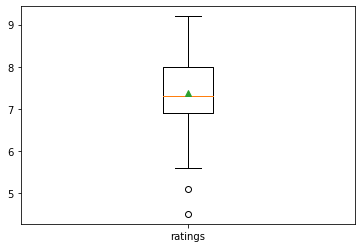

In [25]:
plt.boxplot(simpsons_episodes["imdb_rating"].dropna(), showmeans=True, labels=["ratings"]);

In [26]:
simpsons_episodes.sort_values("imdb_rating").head(2)[["title", "imdb_rating"]]

,title,imdb_rating
id,,
508,Lisa Goes Gaga,4.5
189,"All Singing, All Dancing",5.1


Osservando l'istogramma, si nota come la distribuzione dei valori si avvicini sufficientemente a quella di una gaussiana, fatto testimoniato anche dalla deviazione standard che ha un valore prossimo a 1 (0,73). Possiamo perciò considerare le recensioni come sufficientemente ben distribuite.

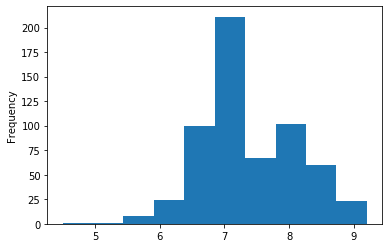

In [27]:
simpsons_episodes["imdb_rating"].plot.hist();

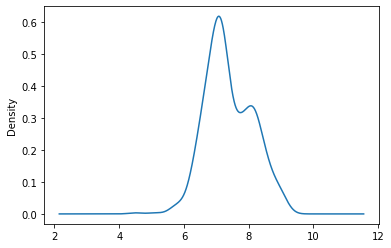

In [28]:
simpsons_episodes["imdb_rating"].plot.density();

Il dataset considera gli episodi de "I Simpson" delle prime 28 stagioni, e nell'ultima non tiene in considerazione tutti gli episodi, ma solamente i primi quattro. È facile osservare come la [ventottesima stagione](https://it.wikipedia.org/wiki/Episodi_de_I_Simpson_(ventottesima_stagione)) abbia infatti ben più di quattro episodi.

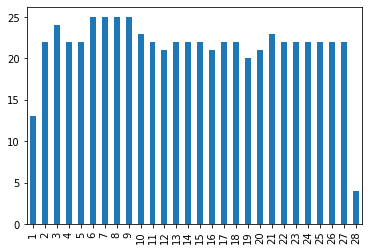

In [29]:
simpsons_episodes["season"].value_counts().sort_index().plot.bar();

Ogni nuovo episodio è andato in onda esclusivamente di domenica, fatta eccezione per un centinaio di episodi, andati in onda di giovedì, e di un numero insignificante alcuni altri nuovi episodi che sono andati in onda nei restanti giorni della settimana. Questo ci dice che questa possibile feature ha scarsa variabilità e non è utile ternerne conto durante la classificazione.

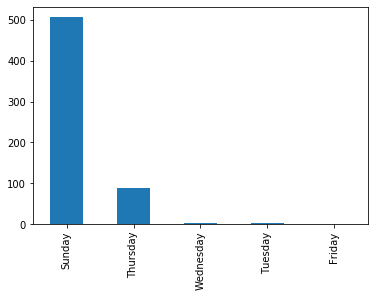

In [30]:
simpsons_episodes.original_air_date.dt.day_name().value_counts().plot.bar();

I nuovi episodi sono andati in onda durante tutto l'anno con all'incirca sempre la stessa frequenza, ad eccezione del periodo esitvo. Questi dati non ci sorprendono però, dato che la stagione televisiva si svolge da settembre a maggio. Quindi anche questo dato non è particolarmente significativo per la classificazione.

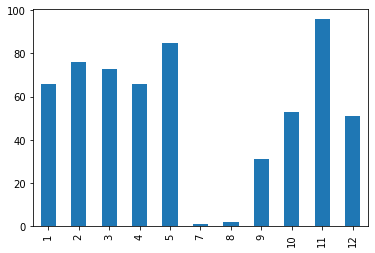

In [31]:
simpsons_episodes.original_air_date.dt.month.value_counts().sort_index().plot.bar();

Un'altra particolarità che notiamo è un fatto di cui tutti gli appassionati della serie sono convinti: le prime stagioni sono considerate mediamente più belle di quelle successive. Dal grafico a barre si nota infatti che per le prime 10 stagioni il punteggio medio è pari o superiore a 7,5 (cioè in media gli episodi sono considerati "belli"), mentre per le stagioni successive la media dei punteggi scende decisamente.

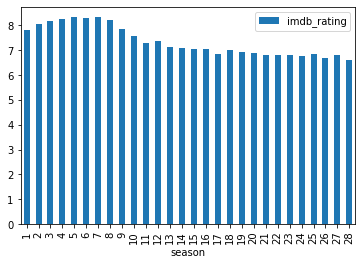

In [32]:
simpsons_episodes.groupby("season").mean().plot.bar();

Mediamente, nel copione di ogni episodio vengono inserite 281 battute di cui 234 vengono pronunciate da un personaggio.

In [33]:
simpsons_script_lines.groupby("episode_id")[["raw_text", "spoken_words"]].count().mean()

raw_text        280.675532
spoken_words    234.289007
dtype: float64

Come si può osservare, il numero di battute tra tutti i copioni che vengono pronunciate è inferiore di 26.000 istanze a quello delle battute in generale nei copioni. Questo per noi non rappresenta un problema, il calo non è significativo, ciò che invece potrebbe rappresentare un problema sono quelle battute che vengono pronunciate dove però non è dato il personaggio che le pronuncia, visto che non può essere sconosciuto. Discorso diverso vale per i luoghi, infatti è possibile che la battuta sia pronunciata in un luogo che nel copione si ignora, perchè magari non viene mostrato. Si nota infatti che le battute pronunciate senza il corrispettivo personaggio sono pochissime, segno di una mancanza di dati dovuta a degli errori, mentre invece le battute senza un luogo specificato sono molte di più, anche se sempre molto poche in confronto a quelle dell'intero *dataset*.

In [34]:
simpsons_script_lines[["raw_text", "spoken_words"]].count()

raw_text        158301
spoken_words    132139
dtype: int64

In [35]:
simpsons_script_lines[~simpsons_script_lines["spoken_words"].isna() & simpsons_script_lines["character_id"].isna()].head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
4213,14,205,Martin Prince: Who would have thought that pushing a boy into the girls' lavatory could be such ...,<NA>,<NA>,Who would have thought that pushing a boy into the girls' lavatory could be such a thrill? The s...
4262,14,254,"Entire Town: A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND."" /",<NA>,<NA>,A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND. /
4266,14,258,"Bart Simpson: (READING ALOUD, WITH HEART) Chapter Six: Four Days in Philadelphia. The first Cont...",<NA>,<NA>,Chapter Six: Four Days in Philadelphia. The first Continental Congress faced a difficult job. Co...
5346,18,200,Tony Bennett: CALLED CAPITAL CITY...,<NA>,<NA>,CALLED CAPITAL CITY...
5349,18,203,Tony Bennett: IN CAPITAL CITY...,<NA>,<NA>,IN CAPITAL CITY...


In [36]:
simpsons_script_lines[~simpsons_script_lines["spoken_words"].isna() & simpsons_script_lines["location_id"].isna()].head()

,episode_id,number,raw_text,character_id,location_id,spoken_words
id,,,,,,
4213,14,205,Martin Prince: Who would have thought that pushing a boy into the girls' lavatory could be such ...,<NA>,<NA>,Who would have thought that pushing a boy into the girls' lavatory could be such a thrill? The s...
4262,14,254,"Entire Town: A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND."" /",<NA>,<NA>,A BEAUTIFUL SIGHT / WE'RE HAPPY TONIGHT/ WALKIN' IN A WINTER WONDERLAND. /
4266,14,258,"Bart Simpson: (READING ALOUD, WITH HEART) Chapter Six: Four Days in Philadelphia. The first Cont...",<NA>,<NA>,Chapter Six: Four Days in Philadelphia. The first Continental Congress faced a difficult job. Co...
4588,16,0,"Marge Simpson: (CLEARING HER THROAT) Hello, everyone. (CLEARING HER THROAT) You know, Halloween ...",1,<NA>,"Hello, everyone. You know, Halloween is a very strange holiday. Personally, I don't understand i..."
5346,18,200,Tony Bennett: CALLED CAPITAL CITY...,<NA>,<NA>,CALLED CAPITAL CITY...


È possibile osservare che in media all'interno di ciascun episodio della serie della serie i personaggi che compaiono hanno 7 battute a testa, anche se questo dato è fortemente sbilanciato: ad esempio la metà dei personaggi a livello di singolo episodio ha una o due battute al massimo e ci sono invece personaggi che in un singolo episodio pronunciano fino a 131 battute. Questo significa che pochi personaggi sono veramente rilevanti nella serie tv.

In [37]:
lines = pd.DataFrame(simpsons_script_lines.dropna(axis="index", subset=["spoken_words"]) \
                                          .groupby(["episode_id", "character_id"]) \
                                          .size(),
                     columns=["size"])
lines.describe()

,size
count,19995.000000
mean,6.607702
std,12.653093
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,131.000000


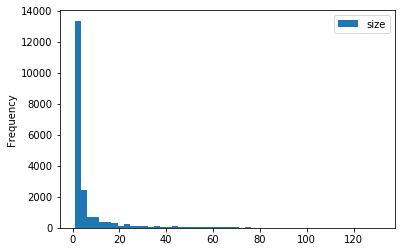

In [38]:
lines.plot.hist(bins=50);

Discorso analogo si può fare per le location. In media in ciascuna location a livello di singolo episodio si pronunciano 13 battute nel copione, però un quarto delle location non compare mai più di tre volte ed esistono location che compaiono fino a 203 volte nelle battute del copione. Quindi, poche location nella serie sono veramente importanti per caratterizzare un episodio.

In [39]:
locations = pd.DataFrame(simpsons_script_lines.dropna(axis="index", subset=["spoken_words"]) \
                                              .groupby(["episode_id", "location_id"]) \
                                              .size(), columns=["size"])
locations.describe()

,size
count,10041.000000
mean,13.120805
std,18.007592
min,1.000000
25%,3.000000
50%,7.000000
75%,15.000000
max,203.000000


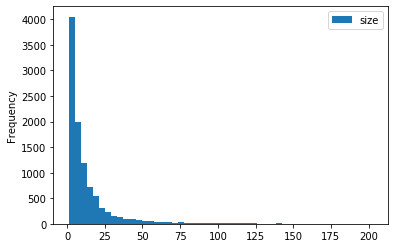

In [40]:
locations.plot.hist(bins=50);

### Rimozione dei valori mancanti e preparazione dei dati

Sulla base di quanto detto, possiamo rimuovere ``original_air_date`` e ``season`` dal DataFrame degli episodi perchè le feature che potremmo estrarre hanno una scarsa variabilità o comunque presentano delle tendenze che vorremmo non influenzassero la nostra classificazione. Inoltre, possiamo rimuovere ``title`` perchè non ci serve più.

In [41]:
simpsons_episodes.drop(columns=["original_air_date", "title", "season"], inplace=True)
simpsons_episodes.head()

,imdb_rating
id,
1,8.2
2,7.8
3,7.5
4,7.8
5,8.1


A questo punto, cerchiamo di sostituire i valori NA di ``character_id`` con quelli corretti quando anche ``spoken_words`` è diverso da NA utilizzando le peculiarità di ``raw_text``. Infatti, generalmente le battute pronunciate nella colonna ``raw_text`` sono precedute dal nome di chi le pronuncia, seguito dai due punti.

In [42]:
missing = simpsons_script_lines[(~simpsons_script_lines["spoken_words"].isna()) & (simpsons_script_lines["character_id"].isna())]
for index, row in missing.iterrows():
    name = row["raw_text"].split(":")[0]
    if name != "":
        simpsons_script_lines.loc[index, "character_id"] = simpsons_characters[simpsons_characters["name"] == name].index

Fatto questo, ``raw_text`` non ci serve più e può essere eliminato.

In [43]:
simpsons_script_lines.drop(columns="raw_text", inplace=True)
simpsons_script_lines.dropna(axis="index", subset=["spoken_words"], inplace=True)
simpsons_script_lines.head()

,episode_id,number,character_id,location_id,spoken_words
id,,,,,
3,1,2,1,2,"Ooo, careful, Homer."
4,1,3,2,2,There's no time to be careful.
5,1,4,2,2,We're late.
8,1,7,1,4,"Sorry, Excuse us. Pardon me..."
9,1,8,2,4,"Hey, Norman. How's it going? So you got dragged down here, too... heh, heh. How ya doing, Fred? ..."


### Selezione delle feature rilevanti

A questo punto, abbiamo ripulito i nostri DataFrame in modo da poterli rielaborare per estrarre la variabile da predire e le feature di nostro interesse. Possiamo procedere dunque con l'unione delle singole battute per ottenere nuovamente i copioni originali di ciascun episodio e successivamente effettuare un *join* tra il DataFrame così ottenuto e quello contenente le informazioni per ciascun episodio così da associare a ciascun copione il suo *rating* su IMDB.

In [44]:
scripts = pd.DataFrame()
simpsons_script_lines.sort_values(["episode_id", "number"], inplace=True)
scripts["spoken_words"] = simpsons_script_lines.groupby("episode_id")["spoken_words"].apply(' '.join)
episodes = simpsons_episodes.join(scripts)
episodes = episodes.astype({
    "spoken_words": "string"
})
episodes.head()

,imdb_rating,spoken_words
id,,
1,8.2,"Ooo, careful, Homer. There's no time to be careful. We're late. Sorry, Excuse us. Pardon me... H..."
2,7.8,"Come on, Mom. Yeah, Mom, hurry up. All right... hmmm... How about ""he""? Two points. Your turn, d..."
3,7.5,"Now, class, I don't want this field trip to be a repeat of our infamous visit to the Springfield..."
4,7.8,"Oh, yeah? Yeah! Oh, yeah? Yeah! Oh, yeah? Yeah! Oh, yeah? Yeah! Hey! What's the problem here? We..."
5,8.1,"Do I smell cupcakes? Oooo, Do I ever! Uh-uh, Homer. Lisa's making these for her teacher. Ah. Say..."


Come si può notare, ci sono 597 episodi con *rating* su IMDB, mentre quelli di cui abbiamo il copione sono solo 564. Non è possibile effetuare la classificazione se il *rating* IMDB è assente e non è molto utile tentare di farlo se il copione non è presente e non abbiamo modo di sapere cosa conteneva. Eliminiamo dunque tutte le righe che presentano valori NA, consapevoli che ci rimangono comunque molte istanze da sfruttare.

In [45]:
episodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1 to 600
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   imdb_rating   597 non-null    float64
 1   spoken_words  564 non-null    string 
dtypes: float64(1), string(1)
memory usage: 14.1 KB


In [46]:
episodes.dropna(inplace=True)

Cerchiamo quindi di costruire altre feature rilevanti che possiamo estrarre da ``simpsons_script_lines``. Possiamo ad esempio associare a ciascun episodio il numero di volte che ciascun personaggio pronuncia una battuta. Poichè i personaggi sono molti, salviamo questi dati in una matrice sparsa e, poichè sappiamo che a livello di singolo episodio un personaggio non pronuncia mai più di 131 battute, possiamo scegliere un tipo di dato più adeguato per salvare questi valori per risparmiare spazio in memoria.

In [47]:
characters = simpsons_script_lines.drop(columns=["number", "location_id", "spoken_words"]) \
                                  .dropna() \
                                  .join(simpsons_characters, on="character_id") \
                                  .drop(columns="character_id") \
                                  .groupby(["episode_id", "name"]) \
                                  .size() \
                                  .unstack() \
                                  .fillna(0) \
                                  .astype(np.uint8) \
                                  .reindex(episodes.index)
characters_cols = characters.columns
characters = csr_matrix(characters)

Possiamo ripetere lo stesso procedimento per le location, associando a ciascun episodio il numero di volte che una battuta è pronunciata in una determinata location, per ciascuna location. Poichè le location sono molte, salviamo anche questi dati in una matrice sparsa. Inoltre, sappiamo che a livello di singolo episodio in una data location non sono mai pronunciate più di 203 battute, perciò possiamo scegliere un tipo di dato più adeguato per salvare questi valori e risparmiare così memoria.

In [48]:
locations = simpsons_script_lines.drop(columns=["number", "character_id", "spoken_words"]) \
                                 .dropna() \
                                 .join(simpsons_locations, on="location_id") \
                                 .drop(columns="location_id") \
                                 .groupby(["episode_id", "name"]) \
                                 .size() \
                                 .unstack() \
                                 .fillna(0) \
                                 .astype(np.uint8) \
                                 .reindex(episodes.index)
locations_cols = locations.columns
locations = csr_matrix(locations)

Fatto questo, possiamo anche sbarazzarci di ``simpsons_episodes`` e ``simpsons_script_lines``, perchè abbiamo estratto tutto ciò che potevamo.

In [49]:
del simpsons_episodes
del simpsons_script_lines

Aggiungiamo quindi la variabile categorica da predire ed eliminiamo la feature del *rating* originale.

In [50]:
episodes["label"] = np.where(episodes["imdb_rating"] >= 7.5, "good", "bad")
episodes.drop(columns="imdb_rating", inplace=True)
episodes = episodes.astype({"label": "string"})
episodes.iloc[5:10]

,spoken_words,label
id,,
6,"Lisa! Lisa, are you still in there? What's the problem? Did you fall in? Lisa! Sorry, Dad. Women...",good
7,"Rusty old hunk of junk. Howdy, Bart. Hot enough for ya? Shut up, Flanders. Hey dad, how come we ...",good
8,"You know, Bart, when I was your age, I pulled a few boners, but I think you'll find that people ...",good
9,"Whoops! Whoops! Oh, whoops... whoops! This is gonna be the best birthday breakfast Mom ever had....",good
10,"So how was the office birthday party? Oh, it was delightful. The frosting on the cake was this t...",bad


Il diagramma a torta ci mostra come le deduzioni sulle distribuzioni dei *rating* fatte in precedenza siano corrette. Infatti, le due classi sono legermente sbilanciate - si trovano in un rapporto 60-40 - verso il "brutto". Non ci preoccuperemo perciò di bilanciare il numero di istanze tra le due classi, essendo molto vicine al perfetto bilanciamento, però terremo conto di questa proporzione quando effettueremo il calcolo dell'accuratezza nei modelli classificazione. Infatti, sarà molto più facile che un modello sia più corretto se tende a classificare molti episodi come "brutto" rispetto ad uno che li classifica invece come "bello".

In [51]:
episodes["label"].value_counts()

bad     325
good    239
Name: label, dtype: Int64

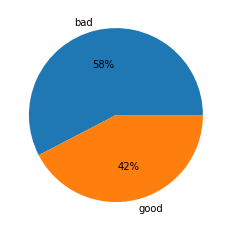

In [52]:
fig, _ = plt.subplots()
plt.pie(episodes["label"].value_counts(), labels=["bad", "good"], autopct="%1.0f%%")
fig.set_facecolor("white")

### Estrazione delle feature testuali

A questo punto cerchiamo di estrarre le feature testuali, ovverosia le parole o quelle parti di esse, che sono più rilevanti dai copioni precedentemente ricostruiti. Prima di tutto dobbiamo ottenere i nostri train e validation set usando sia i copioni originali sia i valori di *rating*, successivamente dobbiamo costruire i *fold* per la *cross-validation*.

In [53]:
X = episodes["spoken_words"]
y = episodes["label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=742)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=742)

#### Scelta del tokenizer

Per prima cosa cerchiamo di trovare il miglior *tokenizer* da applicare sui copioni. Per questo motivo al momento non ci preoccupiamo dell'indice di importanza delle parole, scegliamo il *tf-idf index* perchè il suo calcolo risulta più veloce su questo *dataset*. Detto questo, analizziamo il "caso base" del *vectorizer* e cerchiamo di ridurre via via il numero di feature senza mai compromettere in maniera significativa l'accuratezza del modello preso in esame.

In [54]:
vectorizer_base = TfidfVectorizer()
vectorizer_base.fit_transform(X_train)
features = vectorizer_base.get_feature_names()
features[0:5], features[327:332], features[350:355], features[370:375], features[-5:]

(['00', '000', '007', '07s', '10'],
 ['_______', 'a647253', 'aa', 'aaaa', 'aaaaa'],
 ['aaannnd', 'aaannnnd', 'aaanyway', 'aag', 'aagh'],
 ['abbie', 'abbotan', 'abbots', 'abbreviate', 'abbreviations'],
 ['éclairios', 'êtes', 'être', 'ĉu', 'ĝi'])

Senza applicare nessuna variante, otteniamo 32.933 features, ovvero 32.933 parole, molte delle quali osserviamo essere numeri oppure storpiature di parole inserite solo per rendere meglio l'interpretazione delle frasi. Ha perciò senso provare un metodo di *tokenization* differente per osservare se le feature che estrae sono più significative.

In [55]:
len(features)

32993

Testiamo allora il *tokenizer* del modulo "NLTK".

In [56]:
vectorizer_tokenizer = TfidfVectorizer(tokenizer=nltk.word_tokenize)
vectorizer_tokenizer.fit_transform(X_train)
features = vectorizer_tokenizer.get_feature_names()
features[0:5], features[30:35], features[350:355], features[370:375], features[-5:]

(['!', '#', '$', '%', '&'],
 ["'allo", "'angry", "'appen", "'applause", "'at"],
 ['1977', '1977.', '1979', '1979.', '1980'],
 ['19:19', '19:19.', '19th', '1:00', '1:30'],
 ['é', 'éclairios', 'êtes', 'ĉu', 'ĝi'])

L'uso del *tokenizer* di NLTK ha generato all'incirca 5.000 feature in più, anche se notiamo che in questo caso sembrano essere create con più criterio. Compaiono dei simboli di punteggiatura che prima non avevamo incontrato, che ha senso che vengano considerati in maniera a sè stante, dato che non fanno parte di alcuna parola, e non troviamo più numeri dall'aspetto casuale. Notiamo che sono state aggiunte molte parole apostrofate che il *tokenizer* standard non aveva saputo riconoscere.

In [57]:
len(features)

37661

Proviamo a questo punto a rimuovere gli accenti e le *stop words*, per cercare di trattenere tutte e sole quelle parole che identificano con chiarezza di cosa si sta parlando, eliminando perciò le parole di contorno. Proviamo inoltre a rimuovere la punteggiatura, ovvero sia tutti quei token che non contengono neanche una lettera o un numero.

In [58]:
def tokenize_with_nltk(text):
    return [token for token in nltk.word_tokenize(text) if re.match(r"[a-zA-Z0-9]+", token) is not None]

In [59]:
nltk_stoplist = nltk.corpus.stopwords.words("english")
stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_nltk(word)]))

In [60]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=tokenize_with_nltk, stop_words=stoplist, strip_accents="unicode")
vectorizer_stopwords.fit_transform(X_train)
features = vectorizer_stopwords.get_feature_names()
features[0:5], features[30:35], features[350:355], features[370:375], features[-5:]

(['0', '0.', '007', '1', '1,000'],
 ['10th', '11', '111238,390,17', '1132.', '117th'],
 ['60', '600', '6000', '605', '6051'],
 ['69808,243,293', '6:45', '6th', '7', '7-10'],
 ['zz', 'zz-99', 'zzyzwiski', 'zzzapp', 'zzzzapp'])

La rimozione dei *token* descritti in precedenza non ha giovato particolarmente. Sono state rimosse solamente 400 feature, all'incirca. Evidentemente il metodo usato finora non è stato capace di cogliere tutti quegli elementi che aveva senso rimuovere.

In [61]:
len(features)

37257

#### Applicazione di meccanismi avanzati: POS tagging, lemmatization, stemming

Proviamo a questo punto a complicare la *tokenization* applicandole i meccanismi di *POS tagging*, di lemmatizzazione e di *stemming*. Cerchiamo perciò di ridurre ancora il numero delle feature togliendo anche tutte quelle parole che non sono altro che la variante della stessa dove però tra di esse cambia la declinazione o il tipo dell'elemento grammaticale, caratteristiche che non vanno ad incidere particolarmente sul contenuto generale del discorso.

In [62]:
def tokenize_with_pos(text):
    return nltk.pos_tag(tokenize_with_nltk(text))

In [63]:
pos_stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_pos(word)]))

In [64]:
wnl = nltk.stem.WordNetLemmatizer()
penn_to_wn = {"N": "n", "V": "v", "J": "a", "R": "r"}
def tokenize_with_lemmatization(text):
    return [(wnl.lemmatize(token, penn_to_wn[tag[0]]) if tag[0] in penn_to_wn else token) for token, tag in tokenize_with_pos(text)]

In [65]:
lemmatization_stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_lemmatization(word)]))

In [66]:
ps = nltk.stem.PorterStemmer()
def tokenize_with_stemming(text):
    return [ps.stem(word) for word in tokenize_with_nltk(text)]

In [67]:
stemming_stoplist = list(set([token for word in nltk_stoplist for token in tokenize_with_stemming(word)]))

Questa volta, avendo a disposizione un insieme di valori tra cui scegliere, il *tokenizer* migliore sarà determinato effettuando delle regressioni logistiche di prova, che usano anche la standardizzazione delle feature. Notiamo come l'uso del *POS tagging* aumenta il numero delle feature perchè introduce varianti della stessa parola con però associati diversi tag, dato che una stessa parola può ricoprire più ruoli all'interno del discorso. Il risultato è che l'accuratezza scende, come potevamo aspettarci, anche se non in maniera significativa. La lemmatizzazione invece riesce a ridurre il numero di feature con un aumento dell'accuratezza, ma il metodo migliore si rivela lo *stemming*. Esso infatti riduce più di tutti gli altri il numero delle feature, avendo però l'accuratezza più alta. Useremo perciò quest'ultimo metodo nel prosieguo dell'eliminazione delle feature non rilevanti.

In [68]:
results = []
values = [(tokenize_with_nltk, stoplist),
          (tokenize_with_pos, pos_stoplist),
          (tokenize_with_lemmatization, lemmatization_stoplist),
          (tokenize_with_stemming, stemming_stoplist)]
for i, value in enumerate(values):
    model = Pipeline([
        ("vectorizer", TfidfVectorizer(tokenizer=value[0], stop_words=value[1], strip_accents="unicode")),
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000))
    ])
    result = cross_validate(model, X_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: len(e.named_steps["vectorizer"].get_feature_names()), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=["nltk", "pos", "lemmatization", "stemming"], columns=["mean_test_score", "std_test_score", "number_features"])

,mean_test_score,std_test_score,number_features
nltk,0.733441,0.017348,29885.666667
pos,0.690338,0.013318,45446.333333
lemmatization,0.743562,0.032009,25304.666667
stemming,0.761335,0.032526,22438.000000


#### Ricerca della minimum document frequency, degli ngram, dell'indice di importanza dei termini

Proviamo poi ad eliminare le parole che compaiono troppo di rado, così da rimuovere quelle feature che non sono veramente tali, ma che probabilmente sono solo uno scarto del processo di *tokenization* o che comunque non sono significative perchè sono presenti poche volte in assoluto. Osserviamo che se scegliessimo come ``min_df`` il valore 5, lo score medio sarebbe il più alto in assoluto con una riduzione delle *feature* di circa un fattore 4, ma con il valore 10 avremmo un calo di solo l'1,7% dello *score* rispetto al caso precedente, ma ridurremmo di un fattore 7 le *feature* utilizzate. Scegliamo perciò quest'ultimo come valore per il parametro.

In [69]:
results = []
values = [1, 5, 10, 15]
for i, value in enumerate(values):
    model = Pipeline([
        ("vectorizer", TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=value)),
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000))
    ])
    result = cross_validate(model, X_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: len(e.named_steps["vectorizer"].get_feature_names()), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=values, columns=["mean_test_score", "std_test_score", "number_features"])

,mean_test_score,std_test_score,number_features
1,0.761335,0.032526,22438.000000
5,0.824736,0.041275,4915.666667
10,0.807059,0.025509,2959.333333
15,0.814635,0.024138,2135.000000


Cerchiamo poi di capire se l'utilizzo degli "ngram" permette di migliorare significativamente l'accuratezza del nostro modello oppure no. Come potevamo aspettarci, l'uso degli "ngram" riesce ad aumentare lo *score*, grazie all'aumento delle *feature* nell'operazione di classificazione. Dato che l'aumento è significativo, di circa il 3% se usiamo sia i "3-gram" che i "2-gram", decidiamo di utilizzarli da ora in poi.

In [70]:
results = []
values = [(1, 1), (1, 2), (1, 3)]
for i, value in enumerate(values):
    model = Pipeline([
        ("vectorizer", TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=value)),
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=5000))
    ])
    result = cross_validate(model, X_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: len(e.named_steps["vectorizer"].get_feature_names()), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=[1, 2, 3], columns=["mean_test_score", "std_test_score", "number_features"]) \
  .sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,number_features
3,0.837555,0.021943,4411.666667
2,0.832485,0.012480,4338.333333
1,0.807059,0.025509,2959.333333


Infine, cerchiamo di capire quale indice di importanza delle parole, se il semplice conteggio delle stesse o il *tf-idf index*, è il più adatto per l'utilizzo durante la regressione. L'indice *tf-idf* risulta migliore di circa il 2%, perciò continueremo perciò ad utilizzare "TfidfVectorizer" per la costruzione della nostra matrice documenti-termini.

In [71]:
model = Pipeline([
    ("vectorizer", None),
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=5000))
])
grid = {
    "vectorizer": [TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=(1, 3)),
                   CountVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=(1, 3))]
}
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
results = pd.DataFrame(gs.cv_results_)
results["vectorizer"] = ["TfidfVectorizer", "CountVectorizer"]
results[["vectorizer", "mean_test_score", "std_test_score"]].set_index("vectorizer").sort_values("mean_test_score")

,mean_test_score,std_test_score
vectorizer,,
CountVectorizer,0.817237,0.011122
TfidfVectorizer,0.837555,0.021943


### Unione di feature testuali e non

Ridotte al minimo le feature testuali, si tratta di unirle con quelle non testuali precedentemente estratte per poter eseguire la classificazione. Ci occupiamo allora di ridurre anche il numero di feature non testuali, visto che dall'analisi dei dati molte sono risultate scarsissimamente popolate. Per prima cosa riduciamo il numero dei personaggi tramite l'uso di regolarizzazione "Lasso". L'uso di una regolarizzazione "L1" più forte rende lo score più alto, ma solo se non è troppo forte. Questo è evidentemente segno del fatto che moltissimi personaggi sono irrilevanti ai fini dell'identificazione della qualità di un episodio. Usiamo perciò il coefficiente che ci dà lo score più alto, anche se questo significa sacrificare molti personaggi.

In [72]:
characters_train, characters_val, y_train, y_val = train_test_split(characters, episodes["label"], test_size=0.3, random_state=742)
results = []
values = [1, 5, 7, 10, 0.1, 0.05]
for i, C in enumerate(values):
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, penalty="l1", C=C))
    ])
    result = cross_validate(model, characters_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: (e.named_steps["classifier"].coef_[0] != 0).sum(), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=pd.Index(values, name="C"), columns=["mean_test_score", "std_test_score", "number_features"]) \
  .sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,number_features
C,,,
0.10,0.733403,0.031875,134.333333
5.00,0.720661,0.043197,1907.666667
7.00,0.718136,0.038728,2140.000000
10.00,0.718116,0.044412,2453.333333
1.00,0.707957,0.045905,1070.666667
0.05,0.652171,0.033029,9.333333


Osserviamo che tra i personaggi che abbiamo scartato, moltissimi apparivano solo in una puntata e perciò non erano personaggi ricorrenti, ma semplici comparse a cui erano date delle battute e che non danno quindi alcun contributo nel capire di cosa parla un episodio.

In [73]:
model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, penalty="l1", C=0.1))
    ])
model.fit(characters_train, y_train)
pd.Series(characters_cols[model.named_steps["classifier"].coef_[0] == 0]).head(10)

0           "For Dummies" Author
1    "Just Stamp the Ticket" Man
2                     "Mario" #2
3                  "Shorts" Bart
4                 "Shorts" Homer
5                  "Shorts" Lisa
6                 "Shorts" Marge
7                "Yeeeessss" Man
8                    "Yesss" Man
9                "mad" Writer #1
Name: name, dtype: object

Procediamo quindi alla rimozione dei personaggi irrilevanti, ovvero tutti quelli che si trovano in corrispondenza di *feature* il cui coefficiente è 0, cioè non danno alcun contributo al risultato della classificazione.

In [74]:
characters = csr_matrix(pd.DataFrame(characters.toarray(), columns=characters_cols) \
                          .drop(columns=characters_cols[model.named_steps["classifier"].coef_[0] == 0]))
characters_cols = characters_cols.drop(characters_cols[model.named_steps["classifier"].coef_[0] == 0])
characters

<564x384 sparse matrix of type '<class 'numpy.uint8'>'
	with 4464 stored elements in Compressed Sparse Row format>

Ripetiamo quindi lo stesso procedimento con le *location* per eliminare quelle non particolarmente significative. Anche in questo caso, riusciamo a ridurre significativamente le feature da usare, anche se meno rispetto al caso precedente, usando una regolarizzazione un po' meno intensa. In effetti, le location erano molto sparse su varie feature, ma non così tanto come per i personaggi.

In [75]:
locations_train, locations_val, y_train, y_val = train_test_split(locations, episodes["label"], test_size=0.3, random_state=742)
results = []
values = [1, 3, 5, 0.5, 0.25, 0.1]
for i, C in enumerate(values):
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=50000, penalty="l1", C=C))
    ])
    result = cross_validate(model, locations_train, y_train, cv=skf, return_estimator=True, n_jobs=-1)
    score = result["test_score"]
    features = np.mean(list(map(lambda e: (e.named_steps["classifier"].coef_[0] != 0).sum(), result["estimator"])))
    results.append((score.mean(), score.std(), features))
pd.DataFrame(results, index=pd.Index(values, name="C"), columns=["mean_test_score", "std_test_score", "number_features"]) \
  .sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,number_features
C,,,
0.50,0.654773,0.020793,890.666667
1.00,0.654715,0.038914,1019.333333
0.10,0.639660,0.044496,80.000000
0.25,0.637038,0.007916,728.333333
3.00,0.636980,0.051243,1376.000000
5.00,0.609049,0.052857,1581.666667


Anche in questo caso le *feature* che vogliamo rimuovere sembrano essere quelle legate a *location* che compaiono solo in una puntata e che perciò non incidono sull'apprezzamento delle varie puntate in generale.

In [76]:
model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, penalty="l1", C=1.0))
])
model.fit(locations_train, y_train)
pd.Series(locations_cols[model.named_steps["classifier"].coef_.sum(axis=0) == 0]).head(10)

0    "ALL THE WRONG REASONS" MOVIE THEATER
1              "BOOKS FOR DUMMIES" SECTION
2                          "GUT CHECK" SET
3                           "HEADBUTT" SET
4                  "INCEPTION"-STYLE BEACH
5                      "IT NEVER ENDS" SET
6                         "LAUGH IN" STAGE
7                           "MAD" BUILDING
8                     "MOON BOUNCE" CASTLE
9                             "WALT'S" CAR
Name: name, dtype: object

Procediamo quindi come prima ad eliminare tutte quelle *location* non usate durante la classificazione.

In [77]:
locations = csr_matrix(pd.DataFrame(locations.toarray(), columns=locations_cols) \
                         .drop(columns=locations_cols[model.named_steps["classifier"].coef_[0] == 0]))
locations_cols = locations_cols.drop(locations_cols[model.named_steps["classifier"].coef_[0] == 0])
locations

<564x1476 sparse matrix of type '<class 'numpy.uint8'>'
	with 4654 stored elements in Compressed Sparse Row format>

Finita questa procedura di estrazione, possiamo procedere alla fusione dei nostri tre *set* di *feature* e alla costruzione di *training set* e *validation set* finali. Questo implica, per quanto riguarda i copioni, che dopo aver effettuato il loro *split* costruiamo anche la matrice documenti-termini su quelli presenti nel *training set* e poi ci basiamo su questa per costruire quella del validation set.

In [78]:
words_train, words_val, y_train, y_val, characters_train, characters_val, locations_train, locations_val \
    = train_test_split(episodes["spoken_words"],
                       episodes["label"],
                       characters,
                       locations,
                       test_size=0.3,
                       random_state=742)
vectorizer = TfidfVectorizer(tokenizer=tokenize_with_stemming, stop_words=stemming_stoplist, strip_accents="unicode", min_df=10, ngram_range=(1, 3))
dtm_train = vectorizer.fit_transform(words_train)
dtm_val = vectorizer.transform(words_val)
X_train = hstack([dtm_train, characters_train, locations_train])
X_val = hstack([dtm_val, characters_val, locations_val])
index = vectorizer.get_feature_names() + characters_cols.to_list() + locations_cols.to_list()

Abbiamo perciò a disposizione circa 8.000 feature sulle quali effettuare la nostra classificazione.

In [79]:
X_train.shape[1]

8389

### Test di modelli di classificazione

A questo punto, ottenute tutte le *feature* che abbiamo intenzione di usare, possiamo cercare i modelli che classificano meglio i copioni degli episodi all'interno di ciascuna classe. Per prima cosa definiamo alcune funzioni, come quella per il calcolo dell'intervallo di confidenza, che utilizzeremo per valutare i nostri modelli. In ciascun test faremo inoltre attenzione a bilanciare i pesi delle classi. Infatti, pur non essendoci forti sbilanciamenti tra le due, cerchiamo comunque di favorire quei modelli che riescono ad individuare con maggior accuratezza la classe dalla dimensione più piccola. Nei modelli seguenti non è stato considerato l'uso di *feature* polinomiali perchè avrebbe portato ad un esplosione del loro numero anche con grado basso. Le feature sarebbero diventate infatti circa 30 milioni solamente usando un grado 2.

In [80]:
def confidence_interval(model, X_val, y_val, confidence_level=0.95):
    accuracy = model.score(X_val, y_val)
    size = X_val.shape[0]
    Z = norm.ppf((1 + confidence_level) / 2)
    b = (2 * size * accuracy + Z ** 2) 
    delta_root = Z * np.sqrt(Z ** 2 + 4 * size * accuracy - 4 * size * accuracy ** 2) 
    return (b - delta_root) / (2 * (size + Z ** 2)), (b + delta_root) / (2 * (size + Z**2))

#### Classificazione tramite Perceptron

Iniziamo i nostri test a partire dall'utilizzo di "Perceptron" come metodo per l'individuazione dei modelli migliori, il più semplice.

In [81]:
model_perc = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", Perceptron(random_state=742, max_iter=10000, n_jobs=-1, class_weight="balanced"))
])
grid = [{
    "classifier__penalty": ["l2", "l1", "elasticnet"],
    "classifier__alpha": np.logspace(-2, 2, 5),
    "classifier__eta0": [0.1, 0.5, 0.9]
}, {
    "classifier__penalty": [None],
    "classifier__eta0": [0.1, 0.5, 0.9]
}]

La sua semplicità si riflette nei risultati che otteniamo: nessun tipo di regolarizzazione riesce a migliorare gli score dei modelli testati, che rimangono sempre uguali nonostante la variazione del parametro ``eta0``. Inoltre, i risultati si aggirano attorno all'83,3%, sono perciò decisamente migliorabili.

In [82]:
gs_perc = GridSearchCV(model_perc, grid, cv=skf)
gs_perc.fit(X_train, y_train)
pd.DataFrame(gs_perc.cv_results_)[["param_classifier__penalty", "param_classifier__alpha", "param_classifier__eta0", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__penalty,param_classifier__alpha,param_classifier__eta0,mean_test_score,std_test_score
47,None,NaN,0.9,0.832504,0.022330
46,None,NaN,0.5,0.832504,0.022330
45,None,NaN,0.1,0.832504,0.022330
1,l1,0.01,0.1,0.758925,0.012077
4,l1,0.01,0.5,0.758925,0.012077
7,l1,0.01,0.9,0.758925,0.012077
6,l2,0.01,0.9,0.746183,0.053047
8,elasticnet,0.01,0.9,0.746183,0.053047
3,l2,0.01,0.5,0.738646,0.028769
5,elasticnet,0.01,0.5,0.738646,0.028769


Valutando l'intervallo di confidenza basato sul validation set, vediamo che l'accuratezza può oscillare tra il 63,3% e il 76,9%.

In [83]:
best_perc = gs_perc.best_estimator_
y_pred = best_perc.predict(X_val)
confidence_interval(best_perc, X_val, y_val)

(0.6334475950632291, 0.7692181468999717)

I valori di *precision* e *recall* ci dicono che il migliore modello individuato tende ad essere più preciso nel distinguere dagli altri gli episodi "brutti", rispetto a quanto accade nell'individuare quelli "belli", mentre al contrario tende ad essere più capace, messo di fronte agli episodi "belli", di capire che sono effettivamente "belli", rispetto a quanto capita con quelli "brutti".

In [84]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_perc.classes_, columns=best_perc.classes_)

,bad,good
bad,57,39
good,11,63


In [85]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.84      0.59      0.70        96
        good       0.62      0.85      0.72        74

    accuracy                           0.71       170
   macro avg       0.73      0.72      0.71       170
weighted avg       0.74      0.71      0.70       170



#### Classificazione tramite regressione logistica

Possiamo utilizzare al posto di "Perceptron" un metodo come la regressione logistica, in concomitanza con tutti i possibili tipi di regolarizzazione ammissibili, cioè "Lasso", "Ridge" ed "Elastic Net". Definiamo quindi il nostro modello generale.

In [86]:
model_logreg = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", LogisticRegression(solver="saga", random_state=742, max_iter=10000, class_weight="balanced"))
])

Passiamo poi alla ricerca vera e propria. Se consideriamo le singole regolarizzazioni "Lasso" e "Ridge", il risultato migliore si ha in corrispondenza di una regolarizzazione "Ridge" più intensa. L'uso di una regolarizzazione sempre molto intensa, ma in concomitanza con il tipo "Lasso", fa crollare a picco lo score. Il primo modello che ha uno score comparabile con quello del migliore, ma fa uso della regolarizzazione "Lasso", ha infatti un peso della stessa molto più basso. Evidentemente limitare la dimensione dei coefficienti ha un effetto decisamente più significativo sulle performance di un ipotetico modello rispetto ad eliminare direttamente le feature inutili.

In [87]:
grid_l1_l2 = {
    "classifier__penalty": ["l1", "l2"],
    "classifier__C": np.logspace(-2, 2, 5)
}
gs_l1_l2 = GridSearchCV(model_logreg, grid_l1_l2, cv=skf)
gs_l1_l2.fit(X_train, y_train)
pd.DataFrame(gs_l1_l2.cv_results_)[["param_classifier__penalty", "param_classifier__C", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False)

,param_classifier__penalty,param_classifier__C,mean_test_score,std_test_score
1,l2,0.01,0.880716,0.015642
3,l2,0.1,0.880716,0.015642
8,l1,100,0.880716,0.009448
5,l2,1,0.878171,0.012473
7,l2,10,0.878171,0.012473
9,l2,100,0.878171,0.012473
6,l1,10,0.875607,0.014603
4,l1,1,0.842625,0.007485
2,l1,0.1,0.784255,0.004035
0,l1,0.01,0.525657,0.077068


L'uso della regolarizzazione "Elastic Net" riconferma il risultato già trovato in precedenza, ovverosia che i modelli migliori si hanno quando il peso della regolarizzazione è quasi esclusivamente concentrato sul tipo "Ridge" anzichè sul tipo "Lasso", quindi quelli che presentano un valore di ``l1_ratio`` basso. In questo caso però, il miglior modello estratto si ha in concomitanza con un parametro di regolarizzazione relativamente basso. In ogni caso, il modello con lo *score* migliore lo ha identico ai migliori modelli osservati precedentemente.

In [88]:
grid_elasticnet = {
    "classifier__penalty": ["elasticnet"],
    "classifier__C": np.logspace(-1, 1, 3),
    "classifier__l1_ratio": [0.9, 0.5, 0.1]
}
gs_elasticnet = GridSearchCV(model_logreg, grid_elasticnet, cv=skf)
gs_elasticnet.fit(X_train, y_train)
pd.DataFrame(gs_elasticnet.cv_results_)[["param_classifier__C", "param_classifier__l1_ratio", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__C,param_classifier__l1_ratio,mean_test_score,std_test_score
8,10,0.1,0.880716,0.009448
7,10,0.5,0.875646,0.006977
5,1,0.1,0.870576,0.005813
2,0.1,0.1,0.868031,0.003108
6,10,0.9,0.868031,0.012847
4,1,0.5,0.860359,0.013398
3,1,0.9,0.847695,0.006686
1,0.1,0.5,0.822288,0.013531
0,0.1,0.9,0.789344,0.003284


Non usare nessuna regolarizzazione non porta ad un risultato interessante, perchè il modello ha sì uno score alto, ma è comunque più basso di quelli che utilizzano la regolarizzazione. Perciò, non prenderemo in considerazione quest'ultimo caso.

In [89]:
grid_none = {
    "classifier__penalty": ["none"]
}
gs_none = GridSearchCV(model_logreg, grid_none, cv=skf)
gs_none.fit(X_train, y_train)
pd.DataFrame(gs_none.cv_results_)[["mean_test_score", "std_test_score"]]

,mean_test_score,std_test_score
0,0.878171,0.012473


Osservando l'intervallo di confidenza, vediamo che il valore reale dell'accuratezza del modello migliore, cioè quello che usa la sola regolarizzazione "L2", oscilla tra il 77,2% e l'88,4%.

In [90]:
best_logreg = gs_l1_l2.best_estimator_
y_pred = best_logreg.predict(X_val)
confidence_interval(best_logreg, X_val, y_val)

(0.7722520572638996, 0.8835178653618844)

Dai valori di *precision* e *recall* riusciamo a capire che il migliore modello individuato tramite regressione logstica è superiore a quello individuato tramite "Perceptron" per quanto riguarda quasi tutte le metriche. Peggiora, anche se di poco, la *precision* degli episodi "brutti", ma questo viene compensato da un valore di *recall* della classe "bad" molto più alto. Discorso simile vale per la classe "good" dove la *precision* è salita di più del 20% mentre la *recall* è scesa del 9%. Questo miglioramento complessivo si riflette sull'*f1-score* di entrambe le classi, che fa salire decisamente l'accuratezza.

In [91]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_logreg.classes_, columns=best_logreg.classes_)

,bad,good
bad,86,10
good,18,56


In [92]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.83      0.90      0.86        96
        good       0.85      0.76      0.80        74

    accuracy                           0.84       170
   macro avg       0.84      0.83      0.83       170
weighted avg       0.84      0.84      0.83       170



#### Classificazione mediante Support Vector Machines

Utilizziamo le Support Vector Machines per poter sfruttare un metodo che usa il *kernel trick* per effettuare la classificazione, utilizzando così molte più *feature* di quelle presenti nel *dataset*, senza però la loro effettiva generazione. Notiamo che l'uso di un kernel di tipo sigmoidale è la scelta migliore, in combinazione con il parametro della regolarizzazione "Ridge" pari a 1. Lo score del miglior modello è addirittura superiore allo score del miglior modello ottenuto tramite regressione logistica.

In [93]:
model_svm = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", SVC(random_state=742, class_weight="balanced"))
])
grid_svm = [{
    "classifier__kernel": ["rbf", "sigmoid", "linear"],
    "classifier__C": np.logspace(-2, 2, 5)
}, {
    "classifier__kernel": ["poly"],
    "classifier__degree": [2, 3],
    "classifier__C": np.logspace(-2, 2, 5)
}]
gs_svm = GridSearchCV(model_svm, grid_svm, cv=skf)
gs_svm.fit(X_train, y_train)
pd.DataFrame(gs_svm.cv_results_)[["param_classifier__kernel", "param_classifier__C", "param_classifier__degree", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__kernel,param_classifier__C,param_classifier__degree,mean_test_score,std_test_score
7,sigmoid,1,NaN,0.888388,0.021487
10,sigmoid,10,NaN,0.885805,0.010584
13,sigmoid,100,NaN,0.885805,0.010584
2,linear,0.01,NaN,0.875665,0.017752
5,linear,0.1,NaN,0.875665,0.017752
8,linear,1,NaN,0.875665,0.017752
11,linear,10,NaN,0.875665,0.017752
14,linear,100,NaN,0.875665,0.017752
6,rbf,1,NaN,0.781826,0.041802
12,rbf,100,NaN,0.766597,0.041766


Infatti, l'intervallo di confidenza è molto simile a quello del miglior modello ottenuto tramite regressione logistica, è infatti compreso tra il 78,5% e l'89,3%.

In [94]:
best_svm = gs_svm.best_estimator_
y_pred = best_svm.predict(X_val)
confidence_interval(best_svm, X_val, y_val)

(0.785338347557347, 0.8934410460377628)

Si osserva che l'accuratezza più alta rispetto al miglior modello ottenuto tramite regressione logistica è dovuta ad una maggiore *precision* nell'individuare gli episodi "brutti" e ad una maggiore *recall* della classe "good", non compensata da una minor *precision* nell'individuare gli episodi "belli" e da una minor *recall* della classe "bad". Da questo deriva che entrambi gli *f1-score* sono più alti.

In [95]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_svm.classes_, columns=best_svm.classes_)

,bad,good
bad,80,16
good,10,64


In [96]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.89      0.83      0.86        96
        good       0.80      0.86      0.83        74

    accuracy                           0.85       170
   macro avg       0.84      0.85      0.85       170
weighted avg       0.85      0.85      0.85       170



#### Classificazione tramite XGBoost

Proviamo ad utilizzare anche "XGBoost" per vedere se è capace di darci risultati più interessanti. Per prima cosa lo testiamo senza applicare alcuna regolarizzazione per vedere quali iperparametri propri del classificatore sembrano essere migliori. In un secondo momento vedremo se invece, applicando una regolarizzazione, il risultato è migliorato oppure no. I primi risultati non sono incoraggianti, lo score medio del modello migliore è infatti addirittura inferiore a quello del modello ottenuto con "Perceptron". In particolare, il valore massimo dello score si ha in corrispondenza di un learning rate relativamente piccolo e di una profondità degli alberi non necessariamente alta.

In [97]:
model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", XGBClassifier(objective="binary:logistic", random_state=742, n_jobs=4))
])
grid = [{
    "classifier__learning_rate": np.logspace(-2, 2, 5).tolist(),
    "classifier__max_depth": [5, 10, 15]
}]
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_)[["param_classifier__learning_rate", "param_classifier__max_depth", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__learning_rate,param_classifier__max_depth,mean_test_score,std_test_score
3,0.1,5,0.771416,0.043782
4,0.1,10,0.758771,0.032663
5,0.1,15,0.758771,0.032663
6,1,5,0.746087,0.029551
0,0.01,5,0.735967,0.020871
7,1,10,0.733499,0.012502
8,1,15,0.733499,0.012502
1,0.01,10,0.730877,0.024435
2,0.01,15,0.730877,0.024435
9,10,5,0.581213,0.001499


L'uso dei parametri individuati al passo precedente per costruire un modello su cui testare la regolarizzazione non ci fa ottenere un risultato di tanto migliore, infatti lo *score* aumenta dello 0,3%.

In [98]:
model_xgb = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", XGBClassifier(objective="binary:logistic", learning_rate=0.1, max_depth=10, random_state=742, n_jobs=4))
])
grid_xgb = {
    "classifier__reg_alpha": np.logspace(-2, 2, 5),
    "classifier__reg_lambda": np.logspace(-2, 2, 5),
}
gs_xgb = GridSearchCV(model_xgb, grid_xgb, cv=skf)
gs_xgb.fit(X_train, y_train)
pd.DataFrame(gs_xgb.cv_results_)[["param_classifier__reg_alpha", "param_classifier__reg_lambda", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__reg_alpha,param_classifier__reg_lambda,mean_test_score,std_test_score
0,0.01,0.01,0.773980,0.038676
6,0.1,0.1,0.766366,0.036639
1,0.01,0.1,0.761277,0.040718
12,1,1,0.761277,0.042125
2,0.01,1,0.761238,0.051358
5,0.1,0.01,0.758771,0.031451
10,1,0.01,0.756207,0.038592
7,0.1,1,0.753682,0.035034
13,1,10,0.748651,0.025619
8,0.1,10,0.746087,0.029551


L'intervallo di confidenza calcolato sul *validation set* però ci rivela che i risultati del miglior modello trovato non sono pessimi, in quanto si colloca davanti al miglior modello individuato con "Perceptron", ma si colloca anche dietro ai precedenti due migliori modelli già visti.

In [99]:
best_xgb = gs_xgb.best_estimator_
y_pred = best_xgb.predict(X_val)
confidence_interval(best_xgb, X_val, y_val)

(0.7335414618685494, 0.8532000478492574)

Notiamo infatti che ha una *precision* leggermente più bassa del miglior modello ottenuto con "Perceptron" per quanto riguarda gli episodi "brutti", mentre quella per gli episodi "belli" è cresciuta di molto. La *recall* della classe "bad" è decisamente più alta che nel caso del "Perceptron", mentre quella della classe "good" è più bassa. Complessivamente, ciascun *f1-score* è migliorato producendo un'accuratezza migliore.

In [100]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_xgb.classes_, columns=best_xgb.classes_)

,bad,good
bad,81,15
good,19,55


In [101]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.81      0.84      0.83        96
        good       0.79      0.74      0.76        74

    accuracy                           0.80       170
   macro avg       0.80      0.79      0.80       170
weighted avg       0.80      0.80      0.80       170



#### Classificazione mediante Random Forest

Utilizziamo come ultimo metodo "Random Forest" per vedere se, estraendo regole di partizione delle istanze dal nostro *set* di dati, è capace di ottenere dei risultati migliori rispetto ai metodi già utilizzati. Osserviamo che i risultati migliori non si hanno necessariamente in corrispondenza di un maggior numero di alberi e nemmeno con una profondità degli stessi più alta. Ciò che rimane costante è il numero di istanze per considerare un nodo come una foglia, relativamente basso, e il numero di elementi da raggiungere in un nodo per effettuare lo *split*, un valore non troppo alto. I risultati non sono però soddisfacenti, migliori rispetto a quelli ottenuti con "XGBoost", ma sempre inferiori a quelli di tutti gli altri metodi.

In [102]:
model_rnd = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", RandomForestClassifier(n_jobs=-1, random_state=742, class_weight="balanced"))
])
grid_rnd = {
    "classifier__n_estimators": [100, 200, 500],
    "classifier__max_depth": [2, 4, 8, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__min_samples_split": [3, 5, 10]
}
gs_rnd = GridSearchCV(model_rnd, grid_rnd, cv=skf)
gs_rnd.fit(X_train, y_train)
pd.DataFrame(gs_rnd.cv_results_)[["param_classifier__n_estimators", "param_classifier__max_depth", "param_classifier__min_samples_leaf", "param_classifier__min_samples_split", "mean_test_score", "std_test_score"]] \
  .sort_values("mean_test_score", ascending=False) \
  .head(10)

,param_classifier__n_estimators,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,mean_test_score,std_test_score
37,200,4,2,3,0.817179,0.028977
38,500,4,2,3,0.814596,0.040968
40,200,4,2,5,0.812090,0.031811
71,500,8,2,10,0.807078,0.014732
2,500,2,1,3,0.807040,0.019609
5,500,2,1,5,0.807040,0.019609
8,500,2,1,10,0.807040,0.019609
34,200,4,1,10,0.807001,0.031872
35,500,4,1,10,0.806963,0.047197
53,500,4,4,10,0.806963,0.041968


L'intervallo di accuratezza mostra un miglioramento della stessa rispetto a "Perceptron", ma il valore calcolato è comunque peggiore di quello ottenuto dal miglior modello costruito con "XGBoost".

In [103]:
best_rnd = gs_rnd.best_estimator_
y_pred = best_rnd.predict(X_val)
confidence_interval(best_rnd, X_val, y_val)

(0.7207997534601619, 0.8429322852883191)

Il miglior modello individuato ha una *precision* per gli episodi "belli" che è la stessa del miglior modello ottenuto con "XGBoost", mentre quella degli episodi con valutazione "brutto" è di poco inferiore. La *recall* per la classe "bad" è leggermente più alta del modello di "XGBoost", mentre invece quella della classe "good" è al contrario leggermente più bassa. Questo fa sì che le accuratezze di questi due modelli si discostino di solo l'1%.

In [104]:
pd.DataFrame(confusion_matrix(y_val, y_pred), index=best_rnd.classes_, columns=best_rnd.classes_)

,bad,good
bad,82,14
good,22,52


In [105]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         bad       0.79      0.85      0.82        96
        good       0.79      0.70      0.74        74

    accuracy                           0.79       170
   macro avg       0.79      0.78      0.78       170
weighted avg       0.79      0.79      0.79       170



### Confronto tra modelli

Per poter confrontare più accuratamente i modelli definiamo prima la funzione capace di calcolare se la differenza di accuratezza tra due modelli è statisticamente significativa. Questa ci restituirà gli estremi dell'intervallo di variazione, oltre ad un booleano che ci dice se effettivamente la differenza tra le due accuratezze è statisticamente significativa.

In [106]:
def models_difference_interval(accuracy1, accuracy2, X_size, confidence_level=0.99):
    abs_diff = abs(accuracy1 - accuracy2)
    radius = norm.ppf((1 + confidence_level) / 2) * np.sqrt((accuracy1 * (1 - accuracy1) + accuracy2 * (1 - accuracy2)) / X_size)
    min_int = abs_diff - radius
    max_int = abs_diff + radius
    return min_int, max_int, min_int > 0

Poi defininiamo un modello "dummy", ovverosia un modello che effettui le sue predizioni senza alcun tipo di conoscenza sulle regole interne al *dataset* che permettono di associare un'istanza alla sua classe, facendo perciò le sue predizioni in maniera semi-casuale. In realtà, per fare in modo che il nostro modello di *benchmark* abbia un'accuratezza maggiore, in modo da mettere maggiormente alla prova i modelli precedentemente estratti, non effettuerà la classificazione in maniera completamente casuale, ma assegnerà tutte le istanze alla classe più frequente nel *dataset*. Questo perchè sappiamo esistere un leggero sbilanciamento tra le istanze delle due classi e perciò tutti i modelli che sono più propensi ad assegnare le istanze alla classe più frequente piuttosto che all'altra, avranno automaticamente un certo vantaggio sugli altri modelli.

In [107]:
dummy = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", DummyClassifier(strategy="most_frequent", random_state=742))
])
dummy.fit(X_train, y_train)
dummy.score(X_val, y_val)

0.5647058823529412

Osserviamo che tutti i migliori modelli estratti mediante i metodi utilizzati in precedenza sono significativamente migliori a livello statistico del modello di benchmark con un livello di confidenza del 99%, segno che hanno effetivamente appreso qualcosa dal dataset. Designamo come modello migliore quello ottenuto mediante regressione logistica, che è il secondo con accuratezza più alta. Anche se quest'ultima non è diversa in maniera statisticamente significativa da quella dei migliori modelli ottenuti con "XGBoost", "Random Forest" o "Support Vector Machines", il modello è stato comunque molto capace nel bilanciare *precision* e *recall* delle due classi.

In [108]:
models = [dummy, best_perc, best_logreg, best_svm, best_xgb, best_rnd]
scores = list(map(lambda model: model.score(X_val, y_val), models))
data = []
dummy_accuracy = dummy.score(X_val, y_val)
best_accuracy = max(scores)
for model in models:
    accuracy = model.score(X_val, y_val)
    min_int_dummy, max_int_dummy, significative_dummy = models_difference_interval(accuracy, dummy_accuracy, X_val.shape[0])
    min_int_best, max_int_best, significative_best = models_difference_interval(accuracy, best_accuracy, X_val.shape[0], 0.95)
    data.append((accuracy, min_int_dummy, max_int_dummy, significative_dummy, min_int_best, max_int_best, significative_best))
pd.DataFrame(data,
             index=pd.Index(["Dummy", "Perceptron", "Logistic Regression", "Support Vector Machines", "XGBoost", "Random Forest"], name="model"),
             columns=["accuracy", "lower_bound_interval_dummy", "upper_bound_interval_dummy", "statistically_significative_dummy", "lower_bound_interval_best", "upper_bound_interval_best", "statistically_significative_best"]) \
  .sort_values("accuracy")

,accuracy,lower_bound_interval_dummy,upper_bound_interval_dummy,statistically_significative_dummy,lower_bound_interval_best,upper_bound_interval_best,statistically_significative_best
model,,,,,,,
Dummy,0.564706,-0.138519,0.138519,False,0.190255,0.374451,True
Perceptron,0.705882,0.008148,0.274205,True,0.053891,0.228462,True
Random Forest,0.788235,0.096610,0.350449,True,-0.023026,0.140673,False
XGBoost,0.800000,0.109443,0.361145,True,-0.033829,0.127947,False
Logistic Regression,0.835294,0.148264,0.392913,True,-0.065929,0.089458,False
Support Vector Machines,0.847059,0.161316,0.403390,True,-0.076517,0.076517,False


### Interpretazione della conoscenza

Scelto il modello migliore, osserviamo perciò quali sono le *feature* che sono per esso più incisive per la scelta dell'una o dell'altra classe. Le *feature* che maggiormente portano un episodio ad essere considerato "bello" sembrano essere le esclamazioni - come "ah", "hmmm", "oh", "huh", "hey", "uh huh" - e le loro varianti, le risate - ad esempio "heh heh heh" -, ma anche altre parole come "minute", "sir", "come" ed "everybody". Tutto sommato, queste informazioni sono in linea con quanto ci aspettavamo: gli episodi migliori della serie sono quelli dove vengono trasmesse più emozioni e il pubblico si sente più coinvolto.

In [109]:
coefs = pd.Series(best_logreg.named_steps["classifier"].coef_[0], index).sort_values(ascending=False)
coefs.head(20)

ah                0.034807
heh               0.033439
etc               0.030776
hmmm              0.030340
heh heh           0.029744
oh                0.028886
Simpson Home      0.026432
ohh               0.025481
minut             0.025284
hey wait          0.025239
Maude Flanders    0.025042
sir               0.024916
huh               0.024537
hey               0.024314
heh heh heh       0.024228
uh huh            0.024035
come              0.023422
everybodi         0.023223
ahh               0.023176
uh oh             0.022366
dtype: float64

Se consideriamo solo gli "1-gram" che rendono più probabile che l'episodio abbia un buon *rating*, vediamo come questa teoria è confermata, trovando oltre alle già citate parole anche "ewww". Troviamo però anche due cognomi, "mcclure", appartenente al personaggio di Troy McClure, e "simpson".

In [110]:
coefs[~coefs.index.str.contains(r"[A-Z ]")].head(20)

ah           0.034807
heh          0.033439
etc          0.030776
hmmm         0.030340
oh           0.028886
ohh          0.025481
minut        0.025284
sir          0.024916
huh          0.024537
hey          0.024314
come         0.023422
everybodi    0.023223
ahh          0.023176
ewww         0.022293
hello        0.022077
ooooh        0.021631
simpson      0.021411
mcclure      0.021081
hmm          0.020794
problemo     0.020686
dtype: float64

Al contrario, le *feature* che portano un episodio ad essere considerato "brutto" sembrano essere parole che rappresentano giudizi o in generale aggettivi come "great", "huge", "awesome", "final", "sweet", ma anche parole di uso comune come "everyone", "back", "made", "use", "move", "welcome"... Forse il loro uso in maniera sovrabbondante potrebbe far perdere di significato l'episodio. Troviamo inoltre quella che sembra essere una parola che Marge usa spesso per apostrofare Homer, "homie", nonchè il nome di un personaggio, ovvero "lenny".

In [111]:
coefs.tail(20)

lenni           -0.018666
oh god          -0.019223
na              -0.019448
back            -0.019579
huge            -0.019656
everyon         -0.019709
made            -0.020135
Carl Carlson    -0.020175
great           -0.020190
Springfield     -0.020316
make            -0.021421
use             -0.021571
move            -0.021936
Lenny Leonard   -0.023717
final           -0.024238
awesom          -0.024263
homi            -0.024809
welcom          -0.026117
sweeti          -0.026576
till            -0.028848
dtype: float64

Se consideriamo solo gli "1-gram", oltre alle già discusse parole, troviamo anche "disco" e "god". Evidentemente gli episodi dove si parla di temi religiosi non sono stati molto apprezzati. La parola "disco" fa probabilmente anch'essa riferimento al nome di un personaggio, "Disco Stu".

In [112]:
coefs[~coefs.index.str.contains(r"[A-Z ]")].tail(20)

focu      -0.017902
disco     -0.018030
god       -0.018382
never     -0.018621
lenni     -0.018666
na        -0.019448
back      -0.019579
huge      -0.019656
everyon   -0.019709
made      -0.020135
great     -0.020190
make      -0.021421
use       -0.021571
move      -0.021936
final     -0.024238
awesom    -0.024263
homi      -0.024809
welcom    -0.026117
sweeti    -0.026576
till      -0.028848
dtype: float64

Se ci concentriamo esclusivamente sui personaggi osserviamo che tra quelli che più portano una puntata ad essere apprezzata troviamo i già visti "Maude Flanders" e la "signorina Hoover", ma anche la "signora della mensa", il "signor Smithers", gli anziani e "Jasper", uno degli ospiti della casa di riposo di Springfield, ma anche "Chuck" e "Janey", due compagni di scuola di Bart e Lisa.

In [113]:
best_characters = coefs[characters_cols].sort_values(ascending=False)
best_characters.head(10)

name
Maude Flanders     0.025042
Miss Hoover        0.021896
Lunchlady Doris    0.020350
Waylon Smithers    0.019116
Lewis Clark        0.019043
Singers            0.017712
Old People         0.016658
Chuck              0.015798
JANEY              0.014545
Jasper Beardly     0.014542
dtype: float64

Tra i personaggi che invece abbassano il gradimento di una puntata troviamo il "ricco texano", la businesswoman "Lindsey Naegle", "Brandine", cioè la moglie di Cletus il bifolco, nonchè "Cletus il bifolco" stesso. Quello che hanno in comune questi personaggi è di essere tutti intrinsecamente repubblicani, rappresentando la parte più conservatrice degli Stati Uniti. La serie, di chiaro stampo democratico, satirizza molto questi personaggi e questo potrebbe non essere gradito al pubblico fortemente repubblicano della rete televisiva. Tra gli altri personaggi a sorpresa troviamo "Secco", la madre di Nelson, l'"adolescente dalla voce stridula", ma anche "Disco Stu" e "Lenny" e "Carl", i nomi dei quali avevamo già incontrati in precedenza, come personaggi o come "1-gram" dei loro nomi.

In [114]:
best_characters.tail(10)

name
DOLPH                 -0.012443
The Rich Texan        -0.013368
Lindsay Naegle        -0.014731
Mrs. Muntz            -0.014794
Brandine Del Roy      -0.015579
Disco Stu             -0.016485
Squeaky-Voiced Teen   -0.016614
Cletus Spuckler       -0.017582
Carl Carlson          -0.020175
Lenny Leonard         -0.023717
dtype: float64

Tra i luoghi in cui si svolgono le puntate de "I Simpson" che più portano ad alzare il gradimento di una puntata ci sono casa Simpson e le sue stanze, le stanze della scuola elementare di Springfield, la centrale nucleare, ma anche altri luoghi meno riconoscibili come le vie della città o le automobili. I primi tre luoghi, casa Simpson, la scuola elementare e la centrale nucleare, sono i luoghi dove chiaramente si svolgono il maggior numero di scene degli episodi, i luoghi più ricorrenti, perchè è dove i personaggi passano maggiormente il loro tempo. Evidentemente, quando non è chiaro il luogo in cui si svolge l'azione, nel *dataset* è stato semplicemente etichettato come "Somewhere" e così lì si svolgono molte scene della serie tv e questo porta il suo coefficiente ad essere alto.

In [115]:
best_locations = coefs[locations_cols].sort_values(ascending=False)
best_locations.head(10)

name
Simpson Home                       0.026432
Somewhere                          0.019351
Simpson Kitchen                    0.015717
Simpson Dining Room                0.015626
Miss Hoover's Classroom            0.014022
Springfield Nuclear Power Plant    0.013393
Street                             0.013048
Selma's Car                        0.013000
Downtown Street                    0.012837
Simpson Bathroom                   0.012661
dtype: float64

Tra i luoghi che invece portano il pubblico a dire che un episodio è "brutto" troviamo invece molte più *location* di contorno come il castello di riposo, la spiaggia, le automobili di Homer e di Marge, il tribunale, il garage di casa Simpson, la via dove abitano i Simpson, "Evergreen Terrace", lo stadio, la città di Springfield in generale, che avevamo già incontrato. Evidentemente in questi luoghi si svolgono scene meno rilevanti ai fini della trama o comunque sono luoghi dove più spesso si svolgono scene non interessanti per il pubblico.

In [116]:
best_locations.tail(10)

name
Springfield Retirement Castle   -0.011866
Marge's Car                     -0.011928
Beach                           -0.012087
Homer's Car                     -0.012186
Announcer's Booth               -0.012697
Court                           -0.012950
Simpson Garage                  -0.014004
Evergreen Terrace               -0.015091
STADIUM                         -0.015761
Springfield                     -0.020316
dtype: float64

Notiamo come l'intercetta del nostro modello sia una valore molto piccolo, approssimabile con 0. Questo significa che il nostro modello non conferisce a priori un bonus o un malus ad un episodio prima di classificarlo e perciò entrambe le valutazioni, "bello" o "brutto", hanno la stessa probabilità di essere assegnate ad un episodio a partire dalle parole conenute nel copione di quest'ultimo, dai personaggi e dalle *location* che compaiono.

In [117]:
best_logreg.named_steps["classifier"].intercept_[0]

6.5737984059353544e-06

### Test di reti neurali

#### Classificazione tramite multi-layer perceptron

Proviamo quindi un approccio con un maggior numero di *feature*, ma dove queste sono autonomamente apprese dal metodo stesso, quindi utilizzando una rete neurale. In cambio sacrifichiamo la possibilità di interpretare il nostro modello. Prima di tutto testiamo quella che la libreria "scikit-learn" ci fornisce di base, ovverosia "Multi-Layer Perceptron". Lo *score* medio con i parametri scelti non è troppo distante da quello degli altri modelli valutati precedentemente.

In [118]:
mlp = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("classifier", MLPClassifier(shuffle=True, hidden_layer_sizes=(500, 20), batch_size=10, random_state=742))
])
gs = GridSearchCV(mlp, {}, cv=skf, n_jobs=-1)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_)[["mean_test_score", "std_test_score"]]

,mean_test_score,std_test_score
0,0.862981,0.021324


Anche l'accuratezza non è male, ha un valore comparabile con quella del miglior modello ottenuto con "Random Forest", però non è chiaramente capace di superare il miglior modello in assoluto che siamo riusciti ad individuare.

In [119]:
gs.score(X_val, y_val)

0.788235294117647

#### Classificazione mediante reti neurali convoluzionali

In seconda battuta proviamo a costruire una rete neurale più complessa con l'aiuto delle librerie "Keras" e "TensorFlow", vedendo se un approccio che sfrutta una rete neurale convoluzionale è capace di ottenere dei risultati migliori. Per prima cosa aggiungiamo una colonna fittizia al nostro dataset per rendere le feature scomponibili in sottogruppi.

In [120]:
X_train_nn = hstack([X_train, np.zeros((X_train.shape[0], 1))])
X_train_nn.shape

(394, 8390)

Inseriamo un primo livello di "reshape" per ottenere una matrice 2D da ciascuna istanza, applichiamo poi la convoluzione, e infine facciamo passare gli output attraverso due strati simili a quelli inseriti nel "Multi-Layer Perceptron". Sul primo applichiamo la stessa regolarizzazione del modello migliore trovato in precedenza, mentre prima del secondo applichiamo uno strato di "dropout".

In [121]:
nn = Sequential([
    Reshape((839, 10), input_shape=(X_train_nn.shape[1],)),
    Conv1D(500, 10, activation="relu"),
    Dense(500, activation="relu", kernel_regularizer=l2(100)),
    Flatten(),
    Dropout(0.1, seed=742),
    Dense(20, activation="relu"),
    Dense(2, activation="softmax")
])
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 839, 10)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 830, 500)          50500     
_________________________________________________________________
dense_1 (Dense)              (None, 830, 500)          250500    
_________________________________________________________________
flatten_1 (Flatten)          (None, 415000)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 415000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                8300020   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

Codifichiamo le classi da predire per ciascuna istanza in formato "one-hot encoding", compiliamo il modello facendoci restituire anche la metrica di accuratezza e poi effettuiamo il *fitting*.

In [122]:
y_train_nn = to_categorical(np.where(y_train == "good", 1, 0))
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
fit_history = nn.fit(X_train_nn.toarray(), y_train_nn, epochs=10, batch_size=10);

Epoch 1/10
394/394 [==============================] - 12s 30ms/step - loss: 24980.4072 - accuracy: 0.4746
Epoch 2/10
394/394 [==============================] - 12s 31ms/step - loss: 3053.8943 - accuracy: 0.5838
Epoch 3/10
394/394 [==============================] - 13s 32ms/step - loss: 197.3589 - accuracy: 0.5812
Epoch 4/10
394/394 [==============================] - 13s 32ms/step - loss: 6.2652 - accuracy: 0.5812
Epoch 5/10
394/394 [==============================] - 12s 32ms/step - loss: 0.7331 - accuracy: 0.5812
Epoch 6/10
394/394 [==============================] - 13s 32ms/step - loss: 0.6883 - accuracy: 0.5812
Epoch 7/10
394/394 [==============================] - 12s 32ms/step - loss: 0.6838 - accuracy: 0.5812
Epoch 8/10
394/394 [==============================] - 13s 32ms/step - loss: 0.6850 - accuracy: 0.5812
Epoch 9/10
394/394 [==============================] - 12s 32ms/step - loss: 0.6856 - accuracy: 0.5812
Epoch 10/10
394/394 [==============================] - 12s 31ms/step - lo

Infine valutiamo il modello sul *validation set*, dopo avere adattato anche la sua *shape*. La *categorical cross-entropy* non sembra essere particolarmente alta, ma nemmeno troppo bassa, mentre l'accuratezza, anche se sempre migliore di quella del modello benchmark, è la più bassa tra tutte quelle dei modelli valutati in precedenza. È infatti più bassa di quella del modello ottenuto da "Perceptron", il più scarso tra i metodi che usano *statistical learning*, ma anche di quella del modello ottenuto da "Multi-Layer Perceptron", l'altra rete neurale che abbiamo addestrato.

In [123]:
X_val_nn = hstack([X_val, np.zeros((X_val.shape[0], 1))])
y_val_nn = to_categorical(np.where(y_val == "good", 1, 0))
nn.evaluate(X_val_nn.toarray(), y_val_nn, batch_size=10)

170/170 [==============================] - 1s 7ms/step


[0.6849482024417204, 0.5647059082984924]